<a href="https://colab.research.google.com/github/royaad/AIC/blob/main/%5BSolution%5D_ML_Project_7_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Mask Detection

© 2023, Zaka AI, Inc. All Rights Reserved.

---
The goal of this project is to build a model that can detect whether a person is wearing a mask or not. You would be downloading the data from kaggle and then building you model while we guide you through the steps.


##Getting the Data

We start by getting the data. The data that we want is on kaggle and you can access it through this link: https://www.kaggle.com/omkargurav/face-mask-dataset What you will have to do, is to search for a way that allows you to download the dataset from kaggle directly into google colab (or your google drive). This process would save you the trouble from downloading the dataset locally and then uploading it to use it in colab.

In [ ]:
#Do your Research
#Test Your Zaka
#mounting google drive to fetch the kaggle.json file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#making a temporary kaggle directory
! mkdir ~/.kaggle
#copying kaggle.json from drive to ~./kaggle
!cp '/content/drive/MyDrive/Colab Notebooks/kaggle.json' ~/.kaggle/
#changing access to json file
! chmod 600 ~/.kaggle/kaggle.json
#downloading kaggle dataset
! kaggle datasets download omkargurav/face-mask-dataset

 92% 150M/163M [00:00<00:00, 246MB/s]
100% 163M/163M [00:00<00:00, 240MB/s]


Once the dataset is downloaded, it is going to be zipped, and in order to use it, you need to unzip it. Here you have the option of unzipping it in the environment or in your google drive.

In [ ]:
#Test Your Zaka
# -q (quiet) or -qq (even quieter).
! unzip -q face-mask-dataset.zip

##Importing the Libraries

Now, it is time to import the libraries that we need.

In [ ]:
import os
import shutil
import random
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
from keras.regularizers import l1, l2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support

If we look at the data that we extracted, we can see that it is located in 2 folders: with_mask and without_mask. What we need to do now, is to create a hierarchy of folders that would help us specify the training, validation, and testing data. In order to do this you have to use the **os** and the **shutil** libraries that would help you creating folders, and moving images from a folder to another. In simple terms, the libraries helps you perform the same things that you do on your computer with your operating system, but in a programmatic way.

The initial dataset contains a lot of images belonging to the 2 classes, what we will do is randomly sample from this dataset so that we reduce the training and the tuning time.

We need to have in our final directories the following:
* Training: 500 images "with_mask", and 500 images "without_mask"
* Validation: 100 images "with_mask", and 100 images "without_mask"
* Testing: 50 images "with_mask", and 50 images "without_mask"

In [ ]:
#we can use a dependency called split-folders also
cwd = os.getcwd()
print(cwd)
data_folder = 'data'
data_path = os.path.join(cwd,data_folder)
print(data_path)

/content
/content/data


In [ ]:
#Test Your Zaka --- Create the Train, Validation and Testing Folder
main_folders = ['train', 'validation', 'test']
main_folders_paths = []

for main_folder in main_folders:
    temp_path = os.path.join(data_path,main_folder)
    if not os.path.exists(temp_path):
      main_folders_paths.append(temp_path)
      os.mkdir(temp_path)
    else:
      print(f'warning: \n{temp_path} already exists')
      main_folders_paths.append(temp_path)

In [ ]:
#Test Your Zaka --- Create the classes folders inside of each folder you created above
class_folders = ['with_masks', 'without_masks']
class_folders_paths = []
for main_folder in main_folders_paths:
  for class_folder in class_folders:
    temp_path = os.path.join(main_folder,class_folder)
    if not os.path.exists(temp_path):
      class_folders_paths.append(temp_path)
      os.mkdir(temp_path)
    else:
      print(f'warning: \n{temp_path} already exists')
      class_folders_paths.append(temp_path)

print(class_folders_paths)

['/content/data/train/with_masks', '/content/data/train/without_masks', '/content/data/validation/with_masks', '/content/data/validation/without_masks', '/content/data/test/with_masks', '/content/data/test/without_masks']


In [ ]:
def train_val_test_rand_file_move(source,destinations,n_of_samps,random_state = None):
  #reading list of files (lof) in source
  lof = os.listdir(source)
  #counting the number of files (nof) in source
  nof = len(lof)
  #setting random seed
  if random_state != None:
    random.seed(random_state)
  #total number of samples (tnos)
  tnos = sum(n_of_samps)
  #generating random sampling numbers
  splits_sampling = random.sample(range(nof), tnos)
  #generating splits
  splits = {}
  for i in range(len(n_of_samps)):
    splits[i] = splits_sampling[sum(n_of_samps[:i]):sum(n_of_samps[:i+1])]
  #setting iterator to 0
  iter = 0
  for destination in destinations:
    for sample in splits[iter]:
      #transfer from source file (tsfi)
      tsfi = os.path.join(source,lof[sample])
      #transfer to destination folder (tdfo)
      #if we want a new filename then we must specify the filename in addition to the destination
      tdfo = os.path.join(destination)
      shutil.move(tsfi, tdfo)
    iter +=1

In [ ]:
#setting source folders
#with mask (wim)
wim_folder = 'with_mask'
source_1 = os.path.join(data_path,wim_folder)
print(source_1)
#without mask (wom)
wom_folder = 'without_mask'
source_2 = os.path.join(data_path,wom_folder)
print(source_2)

/content/data/with_mask
/content/data/without_mask


In [ ]:
#setting destinations folders
#with mask
destinations_1 = class_folders_paths[0::2]
print(destinations_1)
#without mask
destinations_2 = class_folders_paths[1::2]
print(destinations_2)

['/content/data/train/with_masks', '/content/data/validation/with_masks', '/content/data/test/with_masks']
['/content/data/train/without_masks', '/content/data/validation/without_masks', '/content/data/test/without_masks']


In [ ]:
#Test Your Zaka --- For each class, take the images, and select 500 samples for training and 100 for evaluation, and 50 for testing
#moving with mask
train_val_test_rand_file_move(source_1,destinations_1,[500, 100, 50],42)
#moving without mask
train_val_test_rand_file_move(source_2,destinations_2,[500, 100, 50],42)

##Inspecting the Dataset

Now we will see some characteristics of our dataset.

Define 3 variables: **training_path**, **validation_path**, and **testing_path** so that you can use them for the rest of the colab.

In [ ]:
#Test Your Zaka
training_path = main_folders_paths[0]
print(training_path)
validation_path = main_folders_paths[1]
print(validation_path)
testing_path = main_folders_paths[2]
print(testing_path)

/content/data/train
/content/data/validation
/content/data/test


To make sure that everything went correctly, write a code that counts the number of images that you have in your training directory for each of the 2 categories: with_mask and without_mask

In [ ]:
#Test Your Zaka
wim_training_path = os.path.join(training_path,'with_masks')
print('The "with_masks" directory has %d' %(len(os.listdir(wim_training_path))))
wom_training_path = os.path.join(training_path,'without_masks')
print('The "without_masks" directory has %d' %(len(os.listdir(wom_training_path))))

The "with_masks" directory has 500
The "without_masks" directory has 500


Do the same for the validation and the testing folders

In [ ]:
#Test Your Zaka
wim_validation_path = os.path.join(validation_path,'with_masks')
print('The "with_masks" directory has %d' %(len(os.listdir(wim_validation_path))))
wom_validation_path = os.path.join(validation_path,'without_masks')
print('The "without_masks" directory has %d' %(len(os.listdir(wom_validation_path))))

The "with_masks" directory has 100
The "without_masks" directory has 100


In [ ]:
#Test Your Zaka
wim_testing_path = os.path.join(testing_path,'with_masks')
print('The "with_masks" directory has %d' %(len(os.listdir(wim_testing_path))))
wom_testing_path = os.path.join(testing_path,'without_masks')
print('The "without_masks" directory has %d' %(len(os.listdir(wom_testing_path))))

The "with_masks" directory has 50
The "without_masks" directory has 50


Write a code that shows 5 random images for people with mask from your training set.

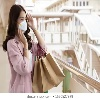

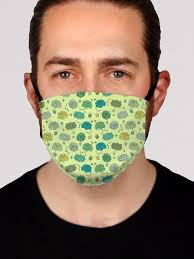

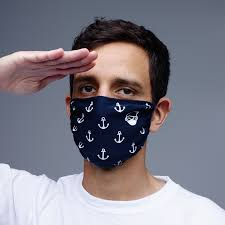

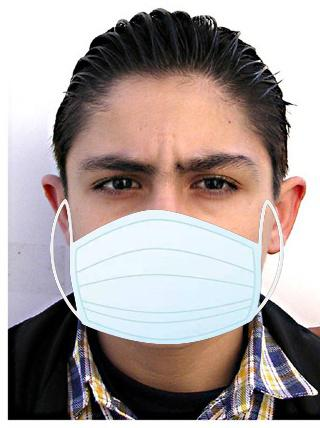

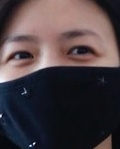

In [ ]:
#Test Your Zaka
#get list of files from directory
lof = os.listdir(wim_training_path)
samples = random.sample(range(len(lof)), 5)
for sample in samples:
  img_path = os.path.join(wim_training_path,lof[sample])
  image = cv2.imread(img_path)
  cv2_imshow(image)

Do the same for people without mask.

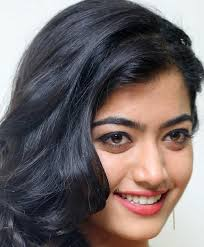

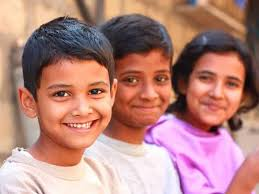

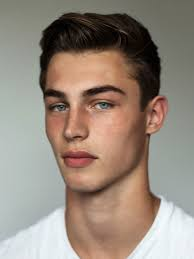

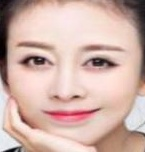

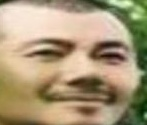

In [ ]:
#Test Your Zaka
#get list of files from directory
lof = os.listdir(wom_training_path)
samples = random.sample(range(len(lof)), 5)
for sample in samples:
  img_path = os.path.join(wom_training_path,lof[sample])
  image = cv2.imread(img_path)
  cv2_imshow(image)

##Modeling

In [ ]:
#Test Your Zaka
#ImageDataGenerator is depricated
#a newer approach is to use tf.data.Dataset API and using the tf.utils.image_dataset_from_directory
#defining batch_size
batch_size = 128
#defining seed for reproducibility
seed = 42
#creating ImageDataGenerator instance
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
#defining input/target image size
IM_WIDTH = 96
IM_HEIGHT = 96
#defining color mode
color_mode = 'rgb'
#creating train/validation/test generators
#the batch size is changed for valid and test since I want all the data in one batch
train_generator = datagen.flow_from_directory(directory = training_path, class_mode = "binary", batch_size = batch_size, target_size=(IM_HEIGHT, IM_WIDTH), color_mode=color_mode, seed = seed)
valid_generator = datagen.flow_from_directory(directory = validation_path, class_mode = "binary", batch_size = 200, target_size=(IM_HEIGHT, IM_WIDTH), color_mode=color_mode, seed = seed)
test_generator = datagen.flow_from_directory(directory = testing_path, class_mode = "binary", batch_size = 100, target_size=(IM_HEIGHT, IM_WIDTH), color_mode=color_mode, seed = seed)
# get batches for training
train_batchX, train_batchy = train_generator.next()
# get info on batches
print('Batch shape = %s, min = %.3f, max = %.3f' %(train_batchX.shape, train_batchX.min(), train_batchX.max()))
print('Data size = %d, Batch size = %d' %(train_generator.n, train_generator.batch_size))
# validation batch
val_batchX, val_batchy = valid_generator.next()
# get info on batches
print('Batch shape = %s, min = %.3f, max = %.3f' %(val_batchX.shape, val_batchX.min(), val_batchX.max()))
print('Data size = %d, Batch size = %d' %(valid_generator.n, valid_generator.batch_size))
# testing batch
test_batchX, test_batchy = test_generator.next()
# get info on batches
print('Batch shape = %s, min = %.3f, max = %.3f' %(test_batchX.shape, test_batchX.min(), test_batchX.max()))
print('Data size = %d, Batch size = %d' %(test_generator.n, test_generator.batch_size))

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Batch shape = (128, 96, 96, 3), min = 0.000, max = 1.000
Data size = 1000, Batch size = 128
Batch shape = (200, 96, 96, 3), min = 0.000, max = 1.000
Data size = 200, Batch size = 200
Batch shape = (100, 96, 96, 3), min = 0.000, max = 1.000
Data size = 100, Batch size = 100


Define a model structure that can deal with the images that we have to classify them between the 2 classes.

In [ ]:
def baseline_model(IM_SIZE=(96, 96), rate=0):
  #model taken (with slight modifications) from reference: https://doi.org/10.1007/s11042-022-12166-x
  IM_HEIGHT, IM_WIDTH = IM_SIZE
  #setting seed value
  seed = 42
  np.random.seed(seed)
  tf.random.set_seed(seed)
  #defining sequential model
  model = tf.keras.Sequential()
  #1st conv / pool
  model.add(tf.keras.layers.Conv2D(16,(3, 3), strides = (1, 1), padding = 'same', activation = 'relu', input_shape = (IM_HEIGHT, IM_WIDTH, 3)))
  model.add(tf.keras.layers.MaxPooling2D())
  #2nd conv / pool
  model.add(tf.keras.layers.Conv2D(32,(3, 3), strides = (1, 1), padding = 'same', activation = 'relu'))
  model.add(tf.keras.layers.MaxPooling2D())
  #3rd conv / pool
  model.add(tf.keras.layers.Conv2D(64,(3, 3), strides = (1, 1), padding = 'same', activation = 'relu'))
  model.add(tf.keras.layers.MaxPooling2D())
  #4th conv / pool
  model.add(tf.keras.layers.Conv2D(128,(3, 3), strides = (1, 1), padding = 'same', activation = 'relu'))
  model.add(tf.keras.layers.MaxPooling2D())
  #5th conv / pool
  model.add(tf.keras.layers.Conv2D(256,(3, 3), strides = (1, 1), padding = 'same', activation = 'relu'))
  model.add(tf.keras.layers.MaxPooling2D())
  #dense layers
  model.add(tf.keras.layers.Flatten())
  #dense layer dropped
  #model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
  model.add(tf.keras.layers.Dropout(rate))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  #summarize
  model.summary()
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  return model

Train the model that you defined on the training data and evaluate it on the validation data. Feel free to tune the hyperparameters of your model until you reach a satisfying result on the validation set. </br>
**N.B:** Make sure to save the model training history in a variable to plot later the learning curve.

In [ ]:
model = baseline_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
#when using train_generator the batch_size is defined by the generator itself.
training_history = model.fit(train_generator, validation_data=valid_generator, epochs=10, verbose=1, callbacks=[es])
print('\nModel Trained!\n')

Epoch 1/10
8/8 [==============================] - 23s 3s/step - loss: 0.6962 - acc: 0.5020 - val_loss: 0.6850 - val_acc: 0.5800
Epoch 2/10
8/8 [==============================] - 24s 3s/step - loss: 0.6332 - acc: 0.7580 - val_loss: 0.4820 - val_acc: 0.8400
Epoch 3/10
8/8 [==============================] - 21s 3s/step - loss: 0.4350 - acc: 0.8100 - val_loss: 0.3369 - val_acc: 0.8750
Epoch 4/10
8/8 [==============================] - 24s 3s/step - loss: 0.3344 - acc: 0.8690 - val_loss: 0.2639 - val_acc: 0.8800
Epoch 5/10
8/8 [==============================] - 19s 2s/step - loss: 0.2885 - acc: 0.8790 - val_loss: 0.2424 - val_acc: 0.8950
Epoch 6/10
8/8 [==============================] - 19s 2s/step - loss: 0.2677 - acc: 0.8920 - val_loss: 0.2330 - val_acc: 0.9050
Epoch 7/10
8/8 [==============================] - 20s 2s/step - loss: 0.2472 - acc: 0.8970 - val_loss: 0.2228 - val_acc: 0.8900
Epoch 8/10
8/8 [==============================] - 19s 2s/step - loss: 0.2296 - acc: 0.9170 - val_loss: 0

Plot the accuracy curve and see if your model is overfit.

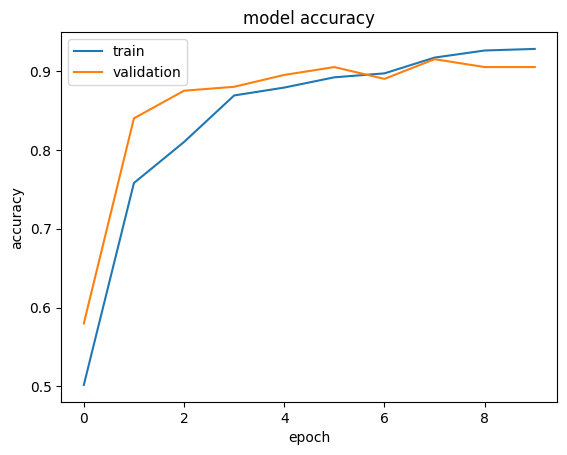

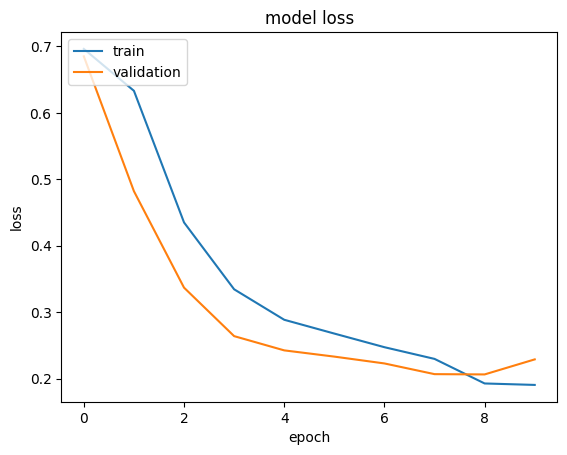

In [ ]:
#Test Your Zaka
# summarize history for training and validation accuracy
plt.plot(training_history.history['acc'])
plt.plot(training_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for training and validation loss
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

<img src="https://storage.googleapis.com/kaggle-media/learn/images/eP0gppr.png" width="500"/>

**Overfitting occurs when the model is left to train for too long. In our case, we are using an early-stop callback to avoid overfitting. We can say we have a minor overfitting since the minimum was reached at epoch 8 and we stopped at epoch 9.**

##Evaluate the model


Now you will evaluate the model that you built on the testing set that you kept aside since the beginning.

In [ ]:
#Test Your Zaka
scores = model.evaluate(test_generator, verbose=0)
print("%s: %.3f" %(model.metrics_names[0], scores[0]))
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

loss: 0.382
acc: 89.00%


Now we want to visualize the confusion matrix in order to see how much our classifier is good in predicting different classes.

The presicion of the model is: 83.1%
The recall of the model is: 98.0%
The F1 score of the model is: 89.9%


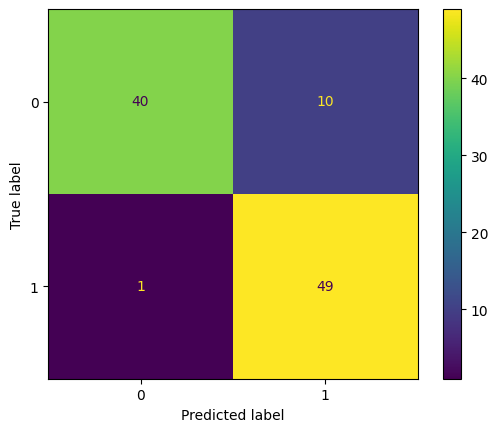

In [ ]:
#Test Your Zaka
y_pred = np.ravel(np.round(model.predict(test_batchX, verbose=0)))

pres, rec, f1s, _ = precision_recall_fscore_support(test_batchy, y_pred,average='binary')
print('The presicion of the model is: %.1f%%' %(100*pres))
print('The recall of the model is: %.1f%%' %(100*rec))
print('The F1 score of the model is: %.1f%%' %(100*f1s))

cm = confusion_matrix(test_batchy, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

**What did you learn about your model from this confusion matrix?**

**The model is a good predictor. In most cases, it has an accuracy of 85\~89%, and has an f1 score of 84\~90%. One key advantage of this model is that it is fast to train.**

##Error Analysis

Now we need to see for each of the images that we have in our testing set, what did the model predict. This helps us analyze the errors and try to think why the model predicted some things in the wrong way.

Predicted: 1 | True: 0


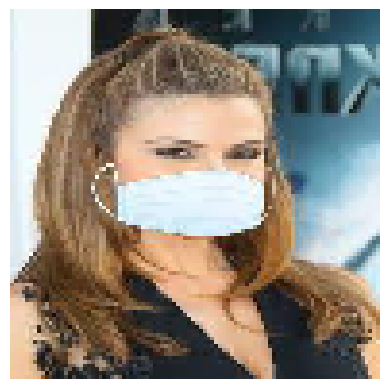

Predicted: 0 | True: 1


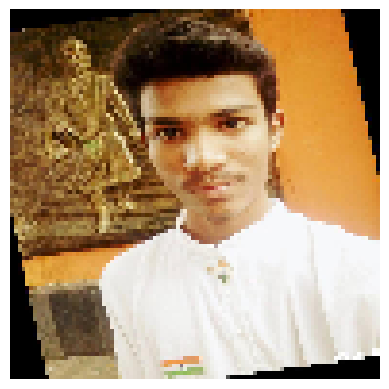

Predicted: 1 | True: 0


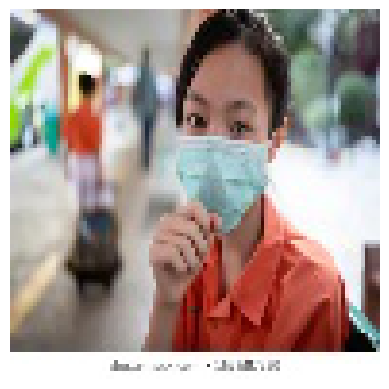

Predicted: 1 | True: 0


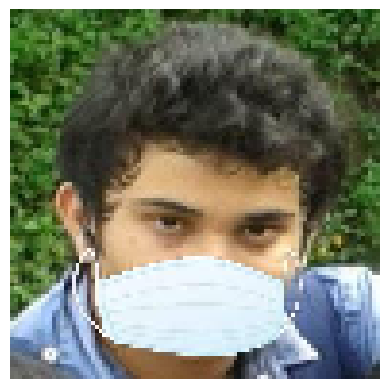

Predicted: 1 | True: 0


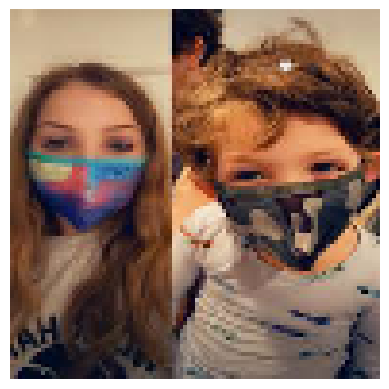

Predicted: 1 | True: 0


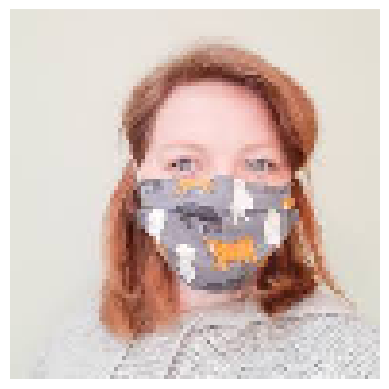

Predicted: 1 | True: 0


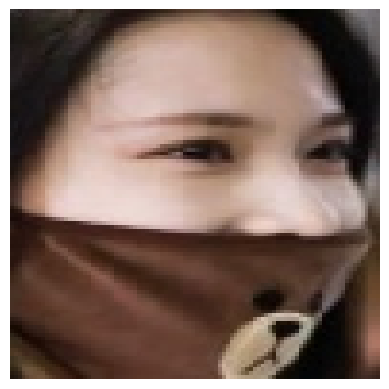

Predicted: 1 | True: 0


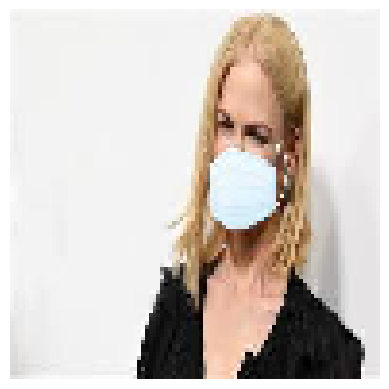

Predicted: 1 | True: 0


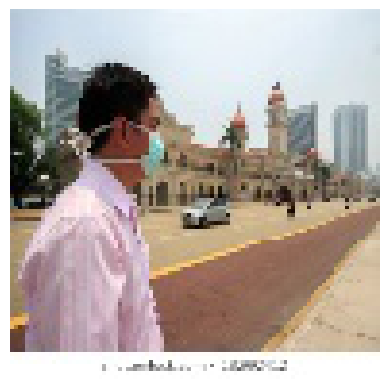

Predicted: 1 | True: 0


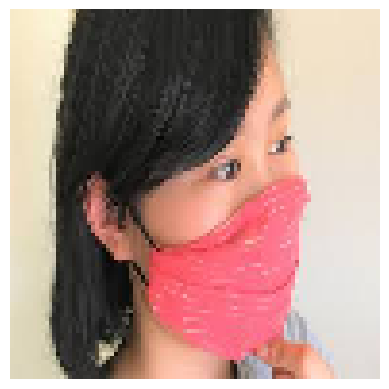

Predicted: 1 | True: 0


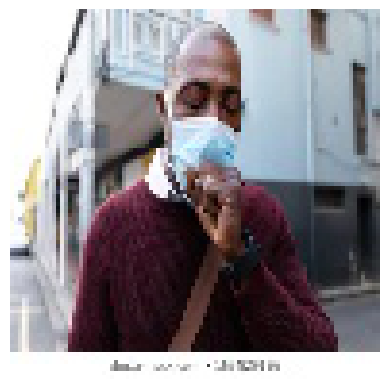

In [ ]:
#Test Your Zaka
ind = np.ravel(np.nonzero(test_batchy-y_pred))

for i in ind:
  print('Predicted: %d | True: %d' %(y_pred[i], test_batchy[i]))
  plt.imshow(test_batchX[i,:,:,:])
  plt.axis('off')
  plt.show()

**Try to derive some conclusions from the wrong predictions that your model has made. Meaning: why do you think these predictions were wrong?**

The model mainly fails the predict faces that are:

*   Looking sideways
*   Have facial hair
*   Have some accessories
*   pictures of cartoons (in some cases)
*   Images that are rotated (in some cases)
*   Have brightness issues (in some cases)
*   Are zoomed partially showing the face/mask (in some cases)
*   Have mask but nose is showing*
*   Masks with patterns or hands placed on them seem to be a challenge.

*This case is also a though decision. The face has a mask but the nose is showing, so the mask in not actually offering real protection. The face picture originates from the with mask dataset. However, from a sanitary point of view (COVID-19 restrictions), the face should be marked as "without protection" or "without a mask". Thus, it is up to the ML engineer with the guidance of public authorities to feature design the algorithm.

**Think of a way that you can use in order to improve the performance of your model, and implement it**

We can think of many options:
* Change the model architecture: Increase the number of filters to get more features or use a deeper network. (will not do, this is similar to last week's challenge)
* Regularization: Apply L1 or L2 regularization, dropout, or batch normalization. (1st attempt)
* Hyperpartameter Tunning. (will not do, this is similar to last week's challenge)
* Increase image input size: This leads to a denser output and therefore should lead to a higher accuracy. (1st attempt)
* Data augmentation: Generate new training samples by applying various transformations to the existing data. This helps to increase the diversity of the training set and improve generalization. (2nd attempt)
* Ensemble learning: Train multiple models with different architectures or initializations and combine their predictions. (small example at the end)
* I would like to propose also "Data Boosting". Similar to Adaboost we retrain the model with a dataset containing more of the images that were hard to classify. (3rd attempt)
* In case the model is predicting much more false positives than false negatives or vice-versa, we can think of tuning the threshold to obtain a higher accuracy.

Of course, we can always combine any of these approaches together.

###1st attempt: Increase resolution & dropout

**This approach in average leads to \~94% accurary, which is 5~6% increase.**

In [ ]:
#Test Your Zaka
#defining batch_size
batch_size = 128
#defining seed for reproducibility
seed = 42
#creating ImageDataGenerator instance
datagen_2 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
#defining input/target image size
IM_WIDTH = 128
IM_HEIGHT = 128
#defining color mode
color_mode = 'rgb'
#creating train/validation/test generators
#the batch size is changed for valid and test since I want all the data in one batch
train_generator_2 = datagen_2.flow_from_directory(directory = training_path, class_mode = "binary", batch_size = batch_size, target_size=(IM_HEIGHT, IM_WIDTH), color_mode=color_mode, seed = seed)
valid_generator_2 = datagen_2.flow_from_directory(directory = validation_path, class_mode = "binary", batch_size = 200, target_size=(IM_HEIGHT, IM_WIDTH), color_mode=color_mode, seed = seed)
test_generator_2 = datagen_2.flow_from_directory(directory = testing_path, class_mode = "binary", batch_size = 100, target_size=(IM_HEIGHT, IM_WIDTH), color_mode=color_mode, seed = seed)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [ ]:
model_2 = baseline_model((128, 128),0.2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 16, 16, 64)      

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
#when using train_generator the batch_size is defined by the generator itself.
training_history_2 = model_2.fit(train_generator_2, validation_data=valid_generator_2, epochs=10, verbose=1, callbacks=[es])
print('\nModel Trained!\n')

Epoch 1/10
8/8 [==============================] - 32s 4s/step - loss: 0.1767 - acc: 0.9350 - val_loss: 0.1752 - val_acc: 0.9350
Epoch 2/10
8/8 [==============================] - 56s 7s/step - loss: 0.1543 - acc: 0.9440 - val_loss: 0.1903 - val_acc: 0.9300
Epoch 3/10
8/8 [==============================] - 31s 4s/step - loss: 0.1416 - acc: 0.9530 - val_loss: 0.1351 - val_acc: 0.9450
Epoch 4/10
8/8 [==============================] - 33s 4s/step - loss: 0.1064 - acc: 0.9630 - val_loss: 0.1532 - val_acc: 0.9300
Epoch 5/10
8/8 [==============================] - 32s 4s/step - loss: 0.1091 - acc: 0.9630 - val_loss: 0.1242 - val_acc: 0.9450
Epoch 6/10
8/8 [==============================] - 32s 4s/step - loss: 0.0801 - acc: 0.9810 - val_loss: 0.1177 - val_acc: 0.9500
Epoch 7/10
8/8 [==============================] - 32s 4s/step - loss: 0.0722 - acc: 0.9740 - val_loss: 0.1134 - val_acc: 0.9400
Epoch 8/10
8/8 [==============================] - 34s 4s/step - loss: 0.0685 - acc: 0.9770 - val_loss: 0

acc: 94.00%


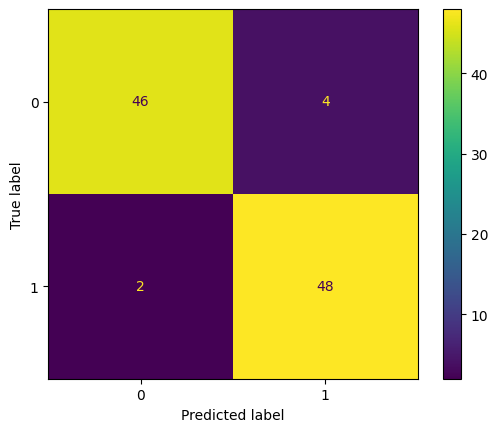

In [ ]:
#Test Your Zaka
test_batchX_2, test_batchy_2 = test_generator_2.next()
scores_2 = model_2.evaluate(test_batchX_2, test_batchy_2, verbose=0)
print("%s: %.2f%%" %(model_2.metrics_names[1], scores_2[1]*100))

y_pred_2 = np.ravel(np.round(model_2.predict(test_batchX_2, verbose=0)))

cm = confusion_matrix(test_batchy_2, y_pred_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

###2nd attempt: Image Augmentation

**This approach can also lead lead to a 93\~96% accurary.**

In [ ]:
#Test Your Zaka
seed = 42
#defining input/target image size
IM_WIDTH = 96
IM_HEIGHT = 96
#samplewise_center=True, samplewise_std_normalization=True, zca_whitening=True, width_shift_range, and height_shift_range gave lower results
#zca made the fitting very slow and did not benefit the accuracy.
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0, rotation_range=30, zoom_range=[0.5, 1.5], brightness_range=[0.5, 1.5], width_shift_range=0, height_shift_range=0)
#only training data should be augmented
aug_train_generator = aug_datagen.flow_from_directory(directory = training_path, class_mode = "binary", batch_size=128, target_size=(IM_HEIGHT, IM_WIDTH), seed=seed)
# get batch
aug_batchX, aug_batchy = aug_train_generator.next()
#fit parameter from data only required for zca and featurewise centering.
#aug_datagen.fit(aug_batchX)
# get info on batches
print('Batch shape=%s, min=%.3f, max=%.3f' % (aug_batchX.shape, aug_batchX.min(), aug_batchX.max()))

Found 1000 images belonging to 2 classes.
Batch shape=(128, 96, 96, 3), min=0.000, max=1.000


In [ ]:
model_3 = baseline_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 12, 12, 64)      

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
training_history_3 = model_3.fit(aug_train_generator, validation_data=valid_generator, epochs=20, verbose=1, callbacks=[es])
print('\nModel Trained!\n')

Epoch 1/20
8/8 [==============================] - 24s 3s/step - loss: 0.6928 - acc: 0.5540 - val_loss: 0.6836 - val_acc: 0.5200
Epoch 2/20
8/8 [==============================] - 23s 3s/step - loss: 0.6520 - acc: 0.6920 - val_loss: 0.5223 - val_acc: 0.8500
Epoch 3/20
8/8 [==============================] - 22s 3s/step - loss: 0.4761 - acc: 0.7880 - val_loss: 0.3863 - val_acc: 0.8550
Epoch 4/20
8/8 [==============================] - 22s 3s/step - loss: 0.3680 - acc: 0.8520 - val_loss: 0.3859 - val_acc: 0.8800
Epoch 5/20
8/8 [==============================] - 22s 3s/step - loss: 0.3864 - acc: 0.8420 - val_loss: 0.3326 - val_acc: 0.8750
Epoch 6/20
8/8 [==============================] - 22s 3s/step - loss: 0.3497 - acc: 0.8570 - val_loss: 0.3668 - val_acc: 0.8600
Epoch 7/20
8/8 [==============================] - 22s 3s/step - loss: 0.3355 - acc: 0.8610 - val_loss: 0.3183 - val_acc: 0.8750
Epoch 8/20
8/8 [==============================] - 22s 3s/step - loss: 0.3183 - acc: 0.8620 - val_loss: 0

acc: 96.00%


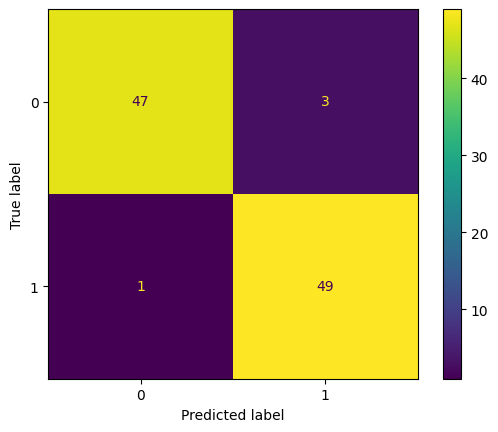

In [ ]:
#Test Your Zaka
scores_3 = model_3.evaluate(test_batchX, test_batchy, verbose=0)
print("%s: %.2f%%" %(model_3.metrics_names[1], scores_3[1]*100))

y_pred_3 = np.ravel(np.round(model_3.predict(test_batchX, verbose=0)))

cm = confusion_matrix(test_batchy, y_pred_3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

###3rd attempt: Boosting **(kinda)**

**This idea is a bit like data augmentation, but inspired by Boosting.**

The idea follows the following steps:

1. The model is fist fitted using the training dataset.
2. After the fit is done, we collect the images that were misclassified by the model.
3. A frequency is calculated based on how badly the picture was misclassified (formula inspired by cross-entropy).
4. A new dataset is generated containing all the pictures of the old dataset.
5. The pictures that were misclassified are, however, repeated (with a minor 15% change) in the new dataset a number of times proportional to their frequency.
6. An iterator is created to pass the new dataset to the model.
7. The model is reseted and re-fit with the new dataset.

**In average, the boosting leads to an increase from 86\~88% to 93~95%.**



In [ ]:
#Test Your Zaka
#defining seed for reproducibility
seed = 42
#creating ImageDataGenerator instance
datagen_3 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
#defining input/target image size
IM_WIDTH = 96
IM_HEIGHT = 96
#defining color mode
color_mode = 'rgb'
#creating train/validation/test generators
#the batch size is changed for all since I want all the data in one batch in order to be able to trace them
train_generator_3 = datagen_3.flow_from_directory(directory = training_path, class_mode = "binary", batch_size = 1000, target_size=(IM_HEIGHT, IM_WIDTH), color_mode=color_mode, seed = seed)
valid_generator_3 = datagen_3.flow_from_directory(directory = validation_path, class_mode = "binary", batch_size = 200, target_size=(IM_HEIGHT, IM_WIDTH), color_mode=color_mode, seed = seed)
test_generator_3 = datagen_3.flow_from_directory(directory = testing_path, class_mode = "binary", batch_size = 100, target_size=(IM_HEIGHT, IM_WIDTH), color_mode=color_mode, seed = seed)
#getting the batches
train_batchX_3, train_batchy_3 = train_generator_3.next()
val_batchX_3, val_batchy_3 = valid_generator_3.next()
test_batchX_3, test_batchy_3 = test_generator_3.next()
# get info on batches
print('Batch shape = %s, min = %.3f, max = %.3f' %(train_batchX_3.shape, train_batchX_3.min(), train_batchX_3.max()))
print('Batch shape = %s, min = %.3f, max = %.3f' %(val_batchX_3.shape, val_batchX_3.min(), val_batchX_3.max()))
print('Batch shape = %s, min = %.3f, max = %.3f' %(test_batchX_3.shape, test_batchX_3.min(), test_batchX_3.max()))

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Batch shape = (1000, 96, 96, 3), min = 0.000, max = 1.000
Batch shape = (200, 96, 96, 3), min = 0.000, max = 1.000
Batch shape = (100, 96, 96, 3), min = 0.000, max = 1.000


In [ ]:
#define model
model_4 = baseline_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
#defining the model fit with all train/val dataset as input, batch_size is requires
training_history_4 = model_4.fit(train_batchX_3, train_batchy_3, validation_data=(val_batchX_3, val_batchy_3), epochs=10, batch_size=128, verbose=1, callbacks=[es])
print('\nModel Trained!\n')

Epoch 1/10
8/8 [==============================] - 18s 2s/step - loss: 0.6853 - acc: 0.5110 - val_loss: 0.6504 - val_acc: 0.5850
Epoch 2/10
8/8 [==============================] - 15s 2s/step - loss: 0.5646 - acc: 0.7470 - val_loss: 0.4963 - val_acc: 0.8000
Epoch 3/10
8/8 [==============================] - 15s 2s/step - loss: 0.4196 - acc: 0.8200 - val_loss: 0.3267 - val_acc: 0.8600
Epoch 4/10
8/8 [==============================] - 15s 2s/step - loss: 0.3357 - acc: 0.8620 - val_loss: 0.2721 - val_acc: 0.8850
Epoch 5/10
8/8 [==============================] - 17s 2s/step - loss: 0.2746 - acc: 0.8970 - val_loss: 0.2580 - val_acc: 0.8700
Epoch 6/10
8/8 [==============================] - 15s 2s/step - loss: 0.2805 - acc: 0.8880 - val_loss: 0.2620 - val_acc: 0.8900
Epoch 7/10
8/8 [==============================] - 15s 2s/step - loss: 0.2586 - acc: 0.9050 - val_loss: 0.2350 - val_acc: 0.9200
Epoch 8/10
8/8 [==============================] - 14s 2s/step - loss: 0.2190 - acc: 0.9200 - val_loss: 0

acc: 86.00%


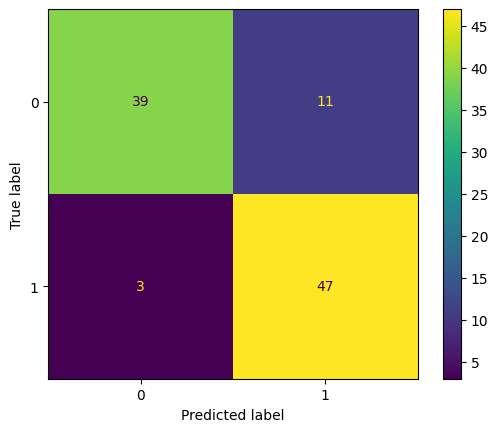

In [ ]:
#Test Your Zaka
scores_4 = model_4.evaluate(test_batchX_3, test_batchy_3, verbose=0)
print("%s: %.2f%%" %(model_4.metrics_names[1], scores_4[1]*100))

y_pred_4 = np.ravel(np.round(model_4.predict(test_batchX_3, verbose=0)))

cm = confusion_matrix(test_batchy_3, y_pred_4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
def img_freq(y_truth, y_proba, y_pred):
  #np.nonzero returns a tuple, np.ravel turns it into a 1d array
  index = np.ravel(np.nonzero(y_truth-y_pred))
  y_proba_miss = y_proba[index]
  y_truth_miss = y_truth[index]
  frequency = y_truth_miss*(0.6/y_proba_miss - 1) + (1 - y_truth_miss)*(1 - 0.4/y_proba_miss)
  frequency = np.ceil(frequency).astype('i')

  return index, frequency

def drop_best_index(y_truth, y_proba, number):

  y_proba_drop = np.abs(y_proba - y_truth)
  indices_to_drop = np.argsort(y_proba_drop)[:number]
  return indices_to_drop

def img_booster(X_in, y_in, ind_to_drop, ind_to_aug, frequencies, Drop=False):
  #first we drop best from the original dataset
  #condition True is needed or else 'All' is considered as True
  if Drop == True:
    X_out = np.delete(X_in, ind_to_drop, axis=0)
    y_out = np.delete(y_in, ind_to_drop)
  elif Drop == 'All':
    X_out = X_in[ind_to_aug,:,:,:]
    y_out = y_in[ind_to_aug]
  else:
    X_out = X_in
    y_out = y_in

  #then we fetch the data we want to focus on
  img_to_aug = X_in[ind_to_aug,:,:,:]
  labels_of_aug = y_in[ind_to_aug]

  #we will insert an augmented version of the data and not the data itself
  #set a rate to change [rotation, zoom, brightness]
  #we will do a slight change on each image
  rzb_rate = [.15, .15, .15] # originally 15% change
  augmentor = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0, rotation_range=rzb_rate[0]*45, zoom_range=[1-rzb_rate[1], 1+rzb_rate[1]], brightness_range=[1-rzb_rate[2], 1+rzb_rate[2]])
  #defining empty array to append to
  aug_imgs = np.empty((0,*img_to_aug.shape[1:]), int)
  aug_imgs_labels = []
  #initiating repeater
  reps = 0
  for freq in frequencies:
    #defining augmented image generator
    #image should be in 4d array so we use [[i],:,:,:]
    #we will not specify a desired size the size of the original batch will stay the same
    generator = augmentor.flow(255*img_to_aug[[reps],:,:,:], batch_size=1)
    for i in range(freq):
      # generate batch of images
      batch = generator.next()
      #appending to empty array
      aug_imgs = np.append(aug_imgs, batch, axis=0)
      aug_imgs_labels.append(labels_of_aug[reps])

    reps+=1

  #appending augmented images to old images
  aug_imgs_labels = np.array(aug_imgs_labels)
  X_out = np.append(X_out,aug_imgs, axis=0)
  y_out = np.append(y_out, aug_imgs_labels, axis=0)
  #shuffling data before returning
  shuffler = random.sample(range(X_out.shape[0]), X_out.shape[0])
  X_out = X_out[shuffler,:,:,:]
  y_out = y_out[shuffler]

  return X_out, y_out

In [ ]:
#getting probabilities and predictions for train set to determine which pictures where badly classified
y_proba_boost = np.ravel(model_4.predict(train_batchX_3, verbose=0))
y_pred_boost = np.round(y_proba_boost)

In [ ]:
#first function takes the y_truth, y_prob, y_pred and determines which pictures where misclassified and assigns a frequency
ind_to_aug, freqs = img_freq(train_batchy_3, y_proba_boost, y_pred_boost)
#print freqs
print(freqs)
#set a ceiling at 5
c_freqs = np.minimum(2*freqs, 10)
#second function takes the y_truth, y_prob, frequencies to determine which pictures where best classified to drop them
ind_to_drop = drop_best_index(train_batchy_3, y_proba_boost, c_freqs.sum())
#third function takes X_in, y_in, ind_to_drop, ind_to_aug, frequencies to drop images and return a new augmented and shuffled dataset with focus on pictures that where misclassified
X_train_boost, y_train_boost = img_booster(train_batchX_3, train_batchy_3, ind_to_drop, ind_to_aug, c_freqs, False)
print(train_batchX_3.shape, train_batchX_3.min(), train_batchX_3.max())
print(train_batchy_3.shape, train_batchy_3.min(), train_batchy_3.max())
print(X_train_boost.shape, X_train_boost.min(), X_train_boost.max())
print(y_train_boost.shape, y_train_boost.min(), y_train_boost.max())

[1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 9 1]
(1000, 96, 96, 3) 0.0 1.0
(1000,) 0.0 1.0
(1152, 96, 96, 3) 0.0 1.0
(1152,) 0.0 1.0


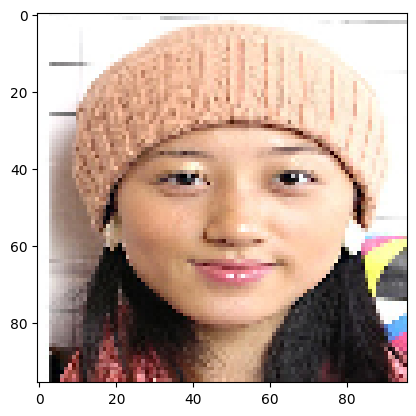

In [ ]:
#checking all is ok
plt.imshow(X_train_boost[542,:,:,:])

In [ ]:
#reseting model
model_5 = baseline_model()
#creating generator
datagen_4 = tf.keras.preprocessing.image.ImageDataGenerator()
#the idea is to only create an iterator
boost_generator = datagen_4.flow(X_train_boost, y_train_boost, batch_size=128)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 48, 48, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 12, 12, 64)      

In [ ]:
#retrain from scratch with boosted train images
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
#defining the model fit with all train/val dataset as input, batch_size is requires
training_history_5 = model_5.fit(boost_generator, validation_data=(val_batchX_3, val_batchy_3), epochs=20, batch_size=128, verbose=1, callbacks=[es])
print('\nModel Trained!\n')

# val_batchX_3, val_batchy_3
#X_val_boost, y_val_boost

Epoch 1/20
9/9 [==============================] - 20s 2s/step - loss: 0.6977 - acc: 0.5182 - val_loss: 0.6876 - val_acc: 0.8300
Epoch 2/20
9/9 [==============================] - 18s 2s/step - loss: 0.6777 - acc: 0.5781 - val_loss: 0.6280 - val_acc: 0.6500
Epoch 3/20
9/9 [==============================] - 16s 2s/step - loss: 0.5678 - acc: 0.7240 - val_loss: 0.4065 - val_acc: 0.8400
Epoch 4/20
9/9 [==============================] - 17s 2s/step - loss: 0.4820 - acc: 0.7830 - val_loss: 0.3376 - val_acc: 0.8550
Epoch 5/20
9/9 [==============================] - 16s 2s/step - loss: 0.4591 - acc: 0.7839 - val_loss: 0.2929 - val_acc: 0.9050
Epoch 6/20
9/9 [==============================] - 17s 2s/step - loss: 0.4316 - acc: 0.8003 - val_loss: 0.3009 - val_acc: 0.9000
Epoch 7/20
9/9 [==============================] - 16s 2s/step - loss: 0.3733 - acc: 0.8411 - val_loss: 0.2714 - val_acc: 0.9050
Epoch 8/20
9/9 [==============================] - 16s 2s/step - loss: 0.3037 - acc: 0.8681 - val_loss: 0

acc: 94.00%


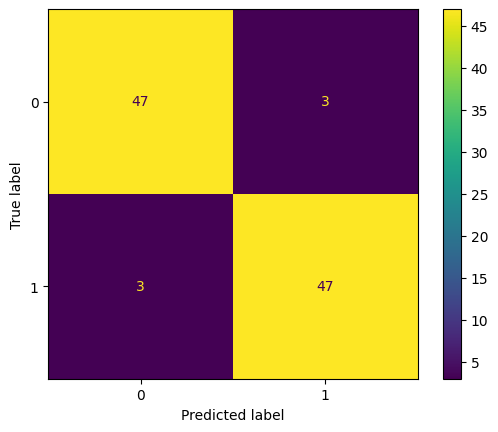

In [ ]:
#Test Your Zaka
scores_5 = model_5.evaluate(test_batchX_3, test_batchy_3, verbose=0)
print("%s: %.2f%%" %(model_5.metrics_names[1], scores_5[1]*100))

y_pred_5 = np.ravel(np.round(model_5.predict(test_batchX_3, verbose=0)))

cm = confusion_matrix(test_batchy_3, y_pred_5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

###Ensemble Method (a small example)

**In the following, we will use a model developped by Emile to do Ensemble Method.**

**I will do the previously trained model_3 and Emile's model, which both gave accuracies above 90%.**

**I will compute the weighted probability using the equation:**

$$ \bar{p} = \frac{\sum \alpha_i p_i}{\sum \alpha_i} $$

**where $\alpha_i$ is the accuracy and $p_i$ is the probability of each model.**

In our case, the ensemble method lead to no great increase. However, it averaged out the probabilities of the two models. In general, Ensemble method is better used with 3 models or more. And since, both models perform well, it is expected that the ensemble method might not lead to a great enhancement. Nevertheless, it could also help overcome the overfitting issue of any giving model, since it accounts for various votes.

####Emile Model

In [ ]:
#Test Your Zaka
#ImageDataGenerator is depricated
#a newer approach is to use tf.data.Dataset API and using the tf.utils.image_dataset_from_directory
#defining batch_size
batch_size = 128
#defining seed for reproducibility
seed = 42
#creating ImageDataGenerator instance
datagen_emile = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
#defining input/target image size
IM_WIDTH = 96
IM_HEIGHT = 96
#defining color mode
color_mode = 'rgb'
#creating train/validation/test generators
#the batch size is changed for valid and test since I want all the data in one batch
train_generator_emile = datagen_emile.flow_from_directory(directory = training_path, class_mode = "categorical", batch_size = batch_size, target_size=(IM_HEIGHT, IM_WIDTH), color_mode=color_mode, seed = seed)
valid_generator_emile = datagen_emile.flow_from_directory(directory = validation_path, class_mode = "categorical", batch_size = 200, target_size=(IM_HEIGHT, IM_WIDTH), color_mode=color_mode, seed = seed)
test_generator_emile = datagen_emile.flow_from_directory(directory = testing_path, class_mode = "categorical", batch_size = 100, target_size=(IM_HEIGHT, IM_WIDTH), color_mode=color_mode, seed = seed)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [ ]:
def model_emile(IM_SIZE=(96, 96), rate=0):

  IM_HEIGHT, IM_WIDTH = IM_SIZE
  #setting seed value
  seed = 42
  np.random.seed(seed)
  tf.random.set_seed(seed)
  #defining sequential model
  model = tf.keras.Sequential()
  #1st conv / pool
  model.add(tf.keras.layers.Conv2D(32,(3, 3), strides = (1, 1), activation = 'relu', input_shape = (IM_HEIGHT, IM_WIDTH, 3)))
  model.add(tf.keras.layers.MaxPooling2D())
  #2nd conv / pool
  model.add(tf.keras.layers.Conv2D(32,(3, 3), strides = (1, 1), activation = 'relu'))
  model.add(tf.keras.layers.MaxPooling2D())
  #3rd conv / pool
  model.add(tf.keras.layers.Conv2D(32,(3, 3), strides = (1, 1), activation = 'relu'))
  model.add(tf.keras.layers.MaxPooling2D())
  #4th conv / pool
  model.add(tf.keras.layers.Conv2D(32,(3, 3), strides = (1, 1), activation = 'relu'))
  model.add(tf.keras.layers.MaxPooling2D())
  #5th conv / pool
  model.add(tf.keras.layers.Conv2D(32,(3, 3), strides = (1, 1), activation = 'relu'))
  model.add(tf.keras.layers.MaxPooling2D())
  #dense layers
  model.add(tf.keras.layers.Flatten())
  #dense layer dropped
  #model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
  model.add(tf.keras.layers.Dropout(rate))
  #model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  model.add(tf.keras.layers.Dense(2, activation='softmax'))
  #summarize
  model.summary()
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
  return model

In [ ]:
model_emile = model_emile()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 22, 22, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 20, 20, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 10, 10, 32)      

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
#when using train_generator the batch_size is defined by the generator itself.
history_emile = model_emile.fit(train_generator_emile, validation_data=valid_generator_emile, epochs=20, verbose=1, callbacks=[es])
print('\nModel Trained!\n')

Epoch 1/20
8/8 [==============================] - 27s 3s/step - loss: 0.6843 - acc: 0.5050 - val_loss: 0.6684 - val_acc: 0.7650
Epoch 2/20
8/8 [==============================] - 19s 3s/step - loss: 0.6289 - acc: 0.7330 - val_loss: 0.5535 - val_acc: 0.8200
Epoch 3/20
8/8 [==============================] - 18s 2s/step - loss: 0.4582 - acc: 0.8240 - val_loss: 0.6030 - val_acc: 0.6200
Epoch 4/20
8/8 [==============================] - 32s 4s/step - loss: 0.4375 - acc: 0.8000 - val_loss: 0.4286 - val_acc: 0.8350
Epoch 5/20
8/8 [==============================] - 31s 4s/step - loss: 0.3669 - acc: 0.8510 - val_loss: 0.3923 - val_acc: 0.8500
Epoch 6/20
8/8 [==============================] - 18s 2s/step - loss: 0.3346 - acc: 0.8590 - val_loss: 0.4403 - val_acc: 0.7550
Epoch 7/20
8/8 [==============================] - 18s 2s/step - loss: 0.3190 - acc: 0.8630 - val_loss: 0.3673 - val_acc: 0.8550
Epoch 8/20
8/8 [==============================] - 18s 2s/step - loss: 0.2888 - acc: 0.8820 - val_loss: 0

In [ ]:
test_batchX_ens, test_batchy_ens = test_generator_emile.next()
y_proba = model_emile.predict(test_batchX_ens, verbose=0)

acc: 96.00%
acc: 92.00%


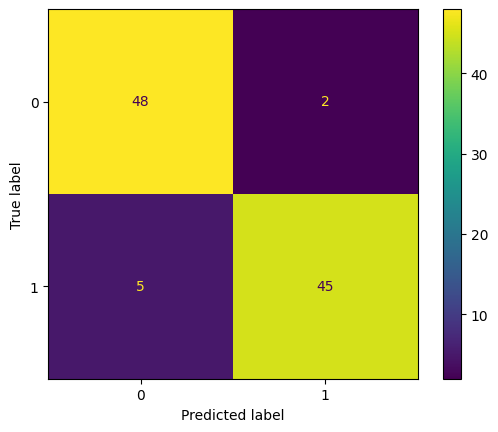

In [ ]:
#Test Your Zaka
scores_i  = model_3.evaluate(test_batchX, test_batchy, verbose=0)
scores_ii = model_emile.evaluate(test_generator_emile, verbose=0)
print("%s: %.2f%%" %(model_3.metrics_names[1], scores_i[1]*100))
print("%s: %.2f%%" %(model_emile.metrics_names[1], scores_ii[1]*100))

y_proba_i = np.ravel((model_3.predict(test_batchX, verbose=0)))
y_proba_ii = model_emile.predict(test_batchX, verbose=0)[:,1]

y_bar = (scores_i[1]*y_proba_i + scores_ii[1]*y_proba_ii)/(scores_i[1]+scores_ii[1])
y_pred_bar = np.round(y_bar)

cm = confusion_matrix(test_batchy, y_pred_bar)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

**Your Friend took your code and ran it again, but obtained different accuracies on the different sets. How do you interpret this?**

**This is quite normal due to the stochastic nature of the neural networks. The weights, biases, and filters are initialized at random. Data is also shuffled at random. And so, all these random processes may lead to a different conversion path for the algorithm. Not to forget that some algorithms, like SGD, are stochastic themselves.**

#Extra: Transfer Learning

##MobileNet Model

**This model worked best**

In [ ]:
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
model = tf.keras.Sequential()
model.add(base_model)
#add custom layers
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
#summarize
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 64)                81984     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,340,033
Trainable params: 82,049
Non-trainable params: 2,257,984
__________________________________________

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)
training_history = model.fit(train_batchX, train_batchY, validation_data=(val_batchX, val_batchy), epochs=10, batch_size = 256, verbose=1, callbacks=[es])
print('\nModel Trained!\n')

Epoch 1/10
4/4 [==============================] - 77s 20s/step - loss: 0.7884 - acc: 0.6100 - val_loss: 0.4514 - val_acc: 0.9200
Epoch 2/10
4/4 [==============================] - 60s 16s/step - loss: 0.3819 - acc: 0.9400 - val_loss: 0.2710 - val_acc: 0.9650
Epoch 3/10
4/4 [==============================] - 59s 16s/step - loss: 0.2437 - acc: 0.9720 - val_loss: 0.2135 - val_acc: 0.9650
Epoch 4/10
4/4 [==============================] - 58s 16s/step - loss: 0.1984 - acc: 0.9770 - val_loss: 0.1838 - val_acc: 0.9850
Epoch 5/10
4/4 [==============================] - 58s 16s/step - loss: 0.1763 - acc: 0.9830 - val_loss: 0.1666 - val_acc: 0.9850
Epoch 6/10
4/4 [==============================] - 58s 16s/step - loss: 0.1611 - acc: 0.9880 - val_loss: 0.1571 - val_acc: 0.9850
Epoch 7/10
4/4 [==============================] - 58s 16s/step - loss: 0.1513 - acc: 0.9890 - val_loss: 0.1500 - val_acc: 0.9900
Epoch 8/10
4/4 [==============================] - 58s 16s/step - loss: 0.1435 - acc: 0.9930 - val

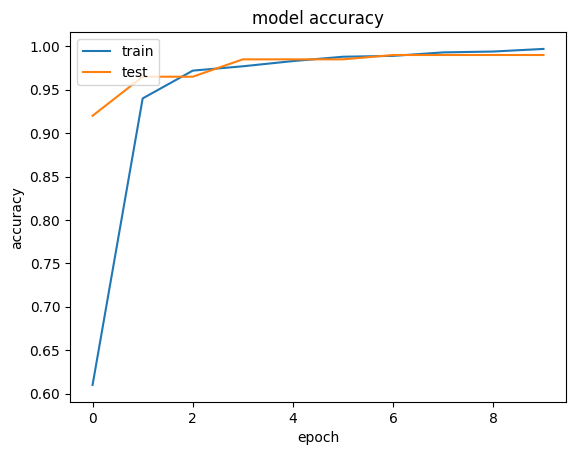

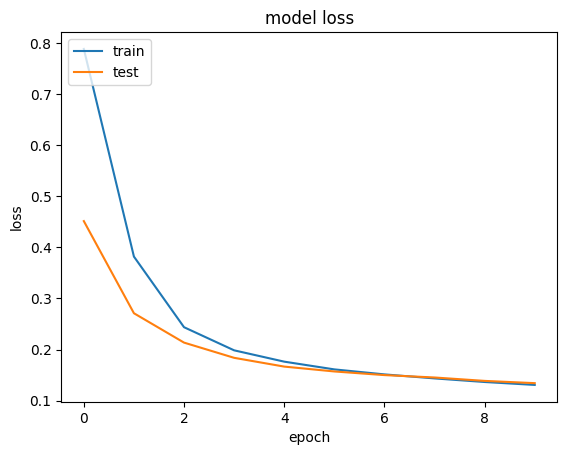

In [ ]:
#Test Your Zaka
# summarize history for training and validation accuracy
plt.plot(training_history.history['acc'])
plt.plot(training_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for training and validation loss
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#Test Your Zaka
scores = model.evaluate(test_batchX, test_batchy, verbose=0)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

acc: 100.00%


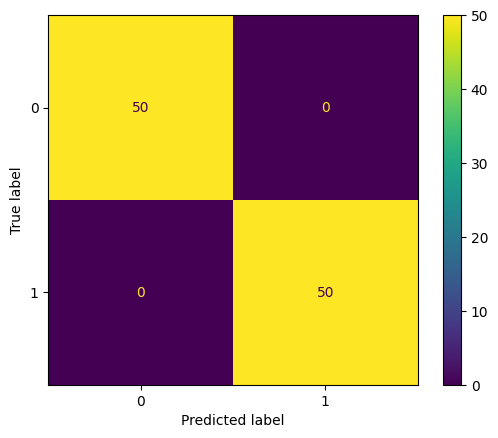

In [ ]:
#Test Your Zaka
y_pred = np.ravel(np.round(model.predict(test_batchX, verbose=0)))

cm = confusion_matrix(test_batchy, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()